In [5]:
import pandas as pd 
from statsbombpy import sb
from mplsoccer import Pitch

In [6]:
competitions = sb.competitions()

In [ ]:
import pandas as pd
import json

all_passes = []


for index, row in filtered_competitions.iterrows():
    competition_id = row['competition_id']
    season_id = row['season_id']
    
    
    print(f"Processing Competition ID: {competition_id}, Season ID: {season_id}")
    
  
    matches = sb.matches(competition_id=competition_id, season_id=season_id)

    for match_id in matches['match_id']:
        print(f"Processing match_id: {match_id}")
        
        try:
            
            events = sb.events(match_id=match_id)

            # Load freeze frame data (360 data) to get all players shown in the broadcast footage when the pass was played
            path_to_json_file = f'/Users/dhruvkaul/open-data/data/three-sixty/{match_id}.json' #To be replaced with your actual path 
            try:
                with open(path_to_json_file, 'r') as file:
                    freeze_frame_data = pd.json_normalize(json.load(file))
            except FileNotFoundError:
                print(f"360 data not found for match_id: {match_id}")
                continue

            # Merge events data with freeze frame data
            merged_data = pd.merge(
                left=events,
                right=freeze_frame_data,
                left_on='id',
                right_on='event_uuid',
                how='left'
            )

            # Filter for pass events
            pass_events = merged_data[merged_data['type'] == 'Pass']

            # Relevant columns for our model
            relevant_columns = [
                'location', 'pass_end_location',
                'pass_length', 'play_pattern', 'pass_angle', 'pass_body_part',
                'freeze_frame', 'pass_height', 'pass_outcome'
            ]
            filtered_pass_data = pass_events[[col for col in relevant_columns if col in pass_events.columns]].copy()

            filtered_pass_data.loc[:, 'pass_outcome'] = filtered_pass_data['pass_outcome'].fillna('Completed')
            filtered_pass_data['pass_outcome'] = filtered_pass_data['pass_outcome'].fillna('Completed')
            filtered_pass_data = filtered_pass_data[filtered_pass_data['pass_outcome'].isin(['Incomplete', 'Completed'])]
            filtered_pass_data = filtered_pass_data[filtered_pass_data['pass_body_part'].isin(['Right Foot', 'Left Foot'])]
            filtered_pass_data.loc[
            filtered_pass_data['pass_body_part'].isin(['Right Foot', 'Left Foot']), 'pass_body_part'
            ] = 'FOOT' #Categorizes all passes made by a right foot or left foot to foot
            filtered_pass_data = filtered_pass_data[filtered_pass_data['play_pattern'].isin(['Regular Play', 'From Free Kick'])] #Only get passes that were made in Regular Play or a Free Kick
            filtered_pass_data = filtered_pass_data[filtered_pass_data['freeze_frame'].notnull()]
            filtered_pass_data = filtered_pass_data[filtered_pass_data['pass_height'].notnull()]

            all_passes.append(filtered_pass_data)

        except Exception as e:
            print(f"Error processing match_id {match_id}: {e}")
            continue


all_passes_df = pd.concat(all_passes, ignore_index=True)
all_passes_df.to_csv("all_passes_testing.csv", index=False)
print(f"Total number of passes extracted: {len(all_passes_df)}")


In [9]:
def calculate_cone_features(passer_location, pass_target, freeze_frame, cone_width=45):
    """
    Calculate features for the cone-shaped area around the pass.
    Args:
        passer_location (list): [x, y] of the passer.
        pass_target (list): [x, y] of the pass target.
        freeze_frame (list): List of players with their positions and team information.
        cone_width (float): Angle of the cone in degrees. We will be using a cone of 45 degrees at this time. This value could change 
        soon though.
    Returns:
        dict: Features calculated within the cone.
    """
    cone_width_radians = np.radians(cone_width / 2)
    
    pass_vector = np.array(pass_target) - np.array(passer_location)
    pass_length = np.linalg.norm(pass_vector)  #Length of the vector
    pass_direction = pass_vector / pass_length  #Normalize to get direction


    opponents_in_cone = 0
    teammates_in_cone = 0
    opponent_distances = []  #Distances of all the opponents to the pass path
    players_in_cone = []
    
   

    for player in freeze_frame:
        player_location = np.array(player['location'])
        is_teammate = player['teammate']

        is_actor = player.get('actor', False)  
        
        #Skip the passer (actor) so it does not get counted
        if is_actor:
            continue

        player_vector = player_location - np.array(passer_location)
        player_distance = np.linalg.norm(player_vector)  #Distance from passer to player

        #Calculate the angle between the pass direction and player vector
        cosine_angle = np.dot(player_vector, pass_direction) / (player_distance + 1e-8)  #Added this to avoid division by zero
        angle = np.arccos(np.clip(cosine_angle, -1, 1)) 

        #Checks if the player is inside the 45 degree cone
        if angle <= cone_width_radians and player_distance <= pass_length:
           
            if is_teammate:
                teammates_in_cone += 1
                players_in_cone.append({
            "location": player_location.tolist(),
            "teammate": is_teammate
        })
            else:
                opponents_in_cone += 1
                players_in_cone.append({
            "location": player_location.tolist(),
            "teammate": False
        })
                #Calculate perpendicular distance to the pass path
                perpendicular_distance = np.linalg.norm(np.cross(player_vector, pass_direction))
                opponent_distances.append(perpendicular_distance)

    features = {
        "opponents_in_cone": opponents_in_cone,
        "teammates_in_cone": teammates_in_cone,
        "average_opponent_distance": np.mean(opponent_distances) if opponent_distances else None,
        "min_opponent_distance": np.min(opponent_distances) if opponent_distances else None
    }
    return features, players_in_cone

In [10]:
import numpy as np

def calculate_gaussian_features(players_in_cone, pass_direction, passer_location, sigma=10):
    """
    Calculate Gaussian-weighted features for players in the cone.

    Args:
        players_in_cone (list): List of players in the cone with their locations and team info.
        pass_direction (np.array): Unit vector of the pass direction.
        passer_location (list): [x, y] coordinates of the passer.
        sigma (float): Standard deviation for the Gaussian function.

    Returns:
        dict: Aggregated features derived from Gaussian weights.
    """
    opponent_weights = []
    teammate_weights = []
    min_opponent_distance = float("inf")

    for player in players_in_cone:
        player_location = np.array(player["location"])
        is_teammate = player["teammate"]

    
        player_vector = player_location - np.array(passer_location)

     
        perpendicular_distance = np.linalg.norm(
            np.cross(player_vector, pass_direction)
        ) / np.linalg.norm(pass_direction)

        #Calculate Gaussian weight
        weight = np.exp(-(perpendicular_distance**2) / (2 * sigma**2))

        if is_teammate:
            teammate_weights.append(weight)
        else:
            opponent_weights.append(weight)
            min_opponent_distance = min(min_opponent_distance, perpendicular_distance)

    features = {
        "opponent_weight_sum": sum(opponent_weights),
        "opponent_weight_mean": np.mean(opponent_weights) if opponent_weights else 0,
        "teammate_weight_sum": sum(teammate_weights),
        "teammate_weight_mean": np.mean(teammate_weights) if teammate_weights else 0,
        "min_opponent_distance": min_opponent_distance if min_opponent_distance != float("inf") else None,
        "num_opponents_in_cone": len(opponent_weights),
        "num_teammates_in_cone": len(teammate_weights),
    }
    return features

In [ ]:
for index, row in all_passes_df.iterrows(): #Iterates through passes to get the Gaussian Weights for opponents and teammates as well as the log ratio.
    passer_location = row['location']  #Pass start location
    pass_target = row['pass_end_location']  #Pass end location
    freeze_frame = row['freeze_frame']  #Player positions

    cone_width = 45
    _, players_in_cone = calculate_cone_features(passer_location, pass_target, freeze_frame, cone_width)

   
    pass_vector = np.array(pass_target) - np.array(passer_location)
    pass_direction = pass_vector / np.linalg.norm(pass_vector)  # Normalize to unit vector

    features = calculate_gaussian_features(players_in_cone, pass_direction, np.array(passer_location))

    all_passes_df.at[index, 'gaussian_opponent_weight'] = features["opponent_weight_sum"]
    all_passes_df.at[index, 'gaussian_teammate_weight'] = features["teammate_weight_sum"]
    log_ratio = np.log((features["opponent_weight_sum"]+ 1e-8) / (features["teammate_weight_sum"]+ 1e-8))
    all_passes_df.at[index, 'log_ratio'] = log_ratio

all_passes_df.to_csv("all_passes_testing.csv", index=False)

In [14]:
class_distribution = all_passes_df['pass_outcome'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
pass_outcome
Completed     119082
Incomplete     18249
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

all_passes_df_copy = all_passes_df.copy()

#The code below breaks down the location of the beginning of the pass and location of the end of the pass into X and Y coordinates.
if 'location' in all_passes_df_copy.columns and 'pass_end_location' in all_passes_df_copy.columns:
    all_passes_df_copy[['x_start', 'y_start']] = pd.DataFrame(all_passes_df_copy['location'].tolist(), index=all_passes_df_copy.index)
    all_passes_df_copy[['x_end', 'y_end']] = pd.DataFrame(all_passes_df_copy['pass_end_location'].tolist(), index=all_passes_df_copy.index)
    print("yes")
else:
    print("Columns 'location' and 'pass_end_location' are missing or not formatted correctly.")

In [78]:
model_results = []


Test Set Performance:
Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     23817
           1       0.45      0.85      0.59      3650

    accuracy                           0.84     27467
   macro avg       0.71      0.85      0.75     27467
weighted avg       0.90      0.84      0.86     27467


AUC-ROC: 0.9161


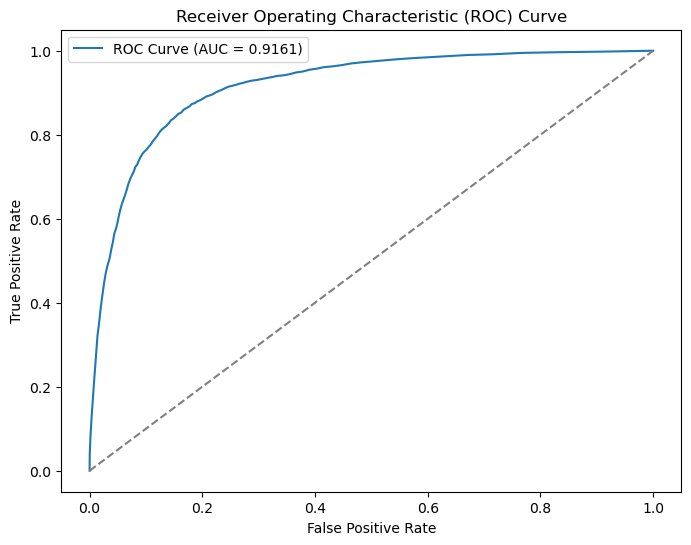


Feature Importances:
                    Feature  Importance
0               pass_length    0.165969
4               pass_height    0.150904
2  gaussian_opponent_weight    0.113441
5                 log_ratio    0.111972
8                     x_end    0.110671
1                pass_angle    0.105916
9                     y_end    0.075377
6                   x_start    0.072987
7                   y_start    0.063225
3  gaussian_teammate_weight    0.029539


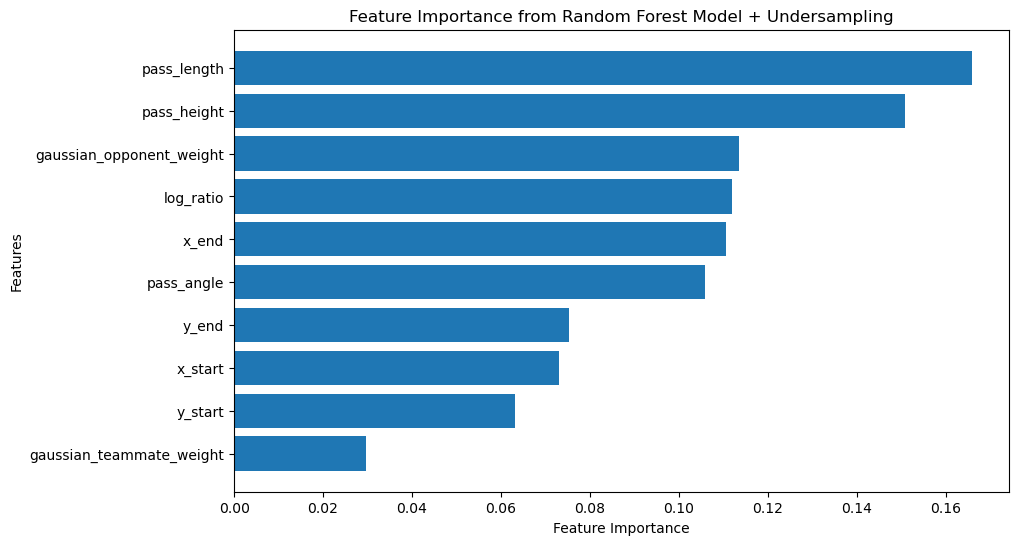

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.metrics import f1_score



#Random Forst + Undersampling


all_passes_df = pd.read_csv("all_passes_testing.csv")

#Map pass types to numerical values
pass_height_mapping = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}
all_passes_df['pass_height'] = all_passes_df['pass_height'].map(pass_height_mapping)


if 'location' in all_passes_df.columns and 'pass_end_location' in all_passes_df.columns:
    all_passes_df[['x_start', 'y_start']] = pd.DataFrame(all_passes_df['location'].apply(eval).tolist(), index=all_passes_df.index)
    all_passes_df[['x_end', 'y_end']] = pd.DataFrame(all_passes_df['pass_end_location'].apply(eval).tolist(), index=all_passes_df.index)
else:
    raise KeyError("Columns 'location' and 'pass_end_location' are missing or not formatted correctly.")


train_data, test_data = train_test_split(
    all_passes_df, test_size=0.2, random_state=42, stratify=all_passes_df['pass_outcome']
)

completed_passes = train_data[train_data['pass_outcome'] == 'Completed']
incomplete_passes = train_data[train_data['pass_outcome'] == 'Incomplete']

#This code undersamples the majority class to the size of the minority class 
completed_undersampled = resample(
    completed_passes,
    replace=False,  
    n_samples=len(incomplete_passes),  
    random_state=42
)


balanced_train_data = pd.concat([completed_undersampled, incomplete_passes]).sample(frac=1, random_state=42)

#These are the features to be passed to the model 
features = ['pass_length', 'pass_angle', 'gaussian_opponent_weight', 
            'gaussian_teammate_weight', 'pass_height', 'log_ratio', 'x_start', 'y_start', 'x_end', 'y_end']
X_train = balanced_train_data[features]
y_train = balanced_train_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})

X_test = test_data[features]
y_test = test_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_test_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)
y_rf_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
aroc = roc_auc_score(y_test, y_test_proba)
rf_recall_class1 = recall_score(y_test, y_rf_pred, pos_label=1) 
rf_precision_class1 = precision_score(y_test, y_rf_pred, pos_label=1) 


model_results.append({
    'Model': 'Random Forest (Undersampling)',
    'Accuracy': accuracy,
    'F1-Score': f1,
    'AUC-ROC': aroc,
    'Recall (Class 1)': rf_recall_class1,
    'Precision (Class 1)': rf_precision_class1
})

print("Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
aroc = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC: {aroc:.4f}")


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {aroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


#We get to know what features the model believes to be important 
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model + Undersampling')
plt.gca().invert_yaxis() 
plt.show()


Class Weights: {0: np.float64(0.5766231039731275), 1: np.float64(3.762723474210562)}

Test Set Performance:
Accuracy: 0.906870062256526
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     23817
           1       0.71      0.51      0.59      3650

    accuracy                           0.91     27467
   macro avg       0.82      0.74      0.77     27467
weighted avg       0.90      0.91      0.90     27467


AUC-ROC: 0.9133


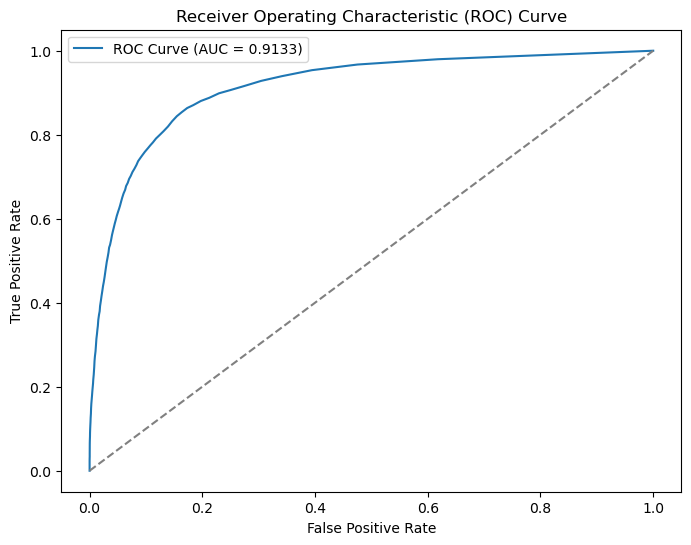


Feature Importances:
                    Feature  Importance
0               pass_length    0.164907
4               pass_height    0.155610
2  gaussian_opponent_weight    0.112562
5                 log_ratio    0.111907
1                pass_angle    0.107289
8                     x_end    0.105334
9                     y_end    0.076294
6                   x_start    0.073150
7                   y_start    0.062889
3  gaussian_teammate_weight    0.030058


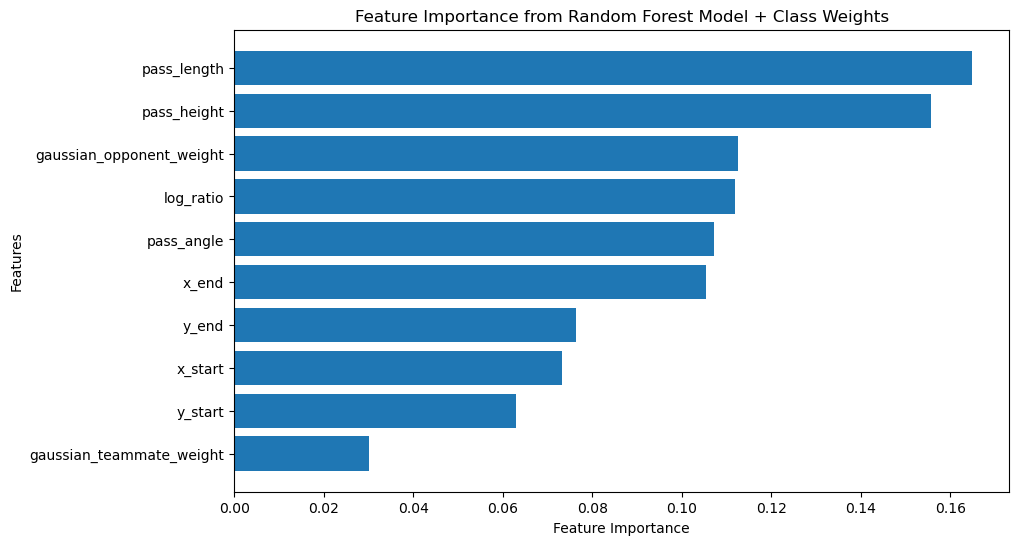

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import mean_squared_error



train_data, test_data = train_test_split(
    all_passes_df_copy,
    test_size=0.2,
    random_state=42,
    stratify=all_passes_df_copy['pass_outcome']
)


features = ['pass_length', 'pass_angle', 'gaussian_opponent_weight', 
            'gaussian_teammate_weight', 'pass_height', 'log_ratio', 'x_start', 'y_start', 'x_end', 'y_end']


X_train = train_data[features]
y_train = train_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})


X_test = test_data[features]
y_test = test_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})

#Class weights will be used for this version of the model
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class Weights: {class_weight_dict}")


rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train, y_train)

y_test_pred = rf_model.predict(X_test)
y_rf_pred = rf_model.predict(X_test)
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
aroc = roc_auc_score(y_test, y_test_proba)
rf_recall_class1 = recall_score(y_test, y_rf_pred, pos_label=1) 
rf_precision_class1 = precision_score(y_test, y_rf_pred, pos_label=1) 
rf_recall_class1 = recall_score(y_test, y_rf_pred, pos_label=1) 
rf_precision_class1 = precision_score(y_test, y_rf_pred, pos_label=1) 


model_results.append({
    'Model': 'Random Forest (Class Weights)',
    'Accuracy': accuracy,
    'F1-Score': f1,
    'AUC-ROC': aroc, 
    'Recall (Class 1)': rf_recall_class1,
    'Precision (Class 1)': rf_precision_class1
})


y_test_proba = rf_model.predict_proba(X_test)[:, 1]  
aroc = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC: {aroc:.4f}")


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {aroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model + Class Weights')
plt.gca().invert_yaxis() 
plt.show()

Training Gradient Boosting...

Test Set Performance:
Accuracy: 0.8458149779735683
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     23817
           1       0.46      0.85      0.59      3650

    accuracy                           0.85     27467
   macro avg       0.71      0.85      0.75     27467
weighted avg       0.90      0.85      0.86     27467


AUC-ROC: 0.9207


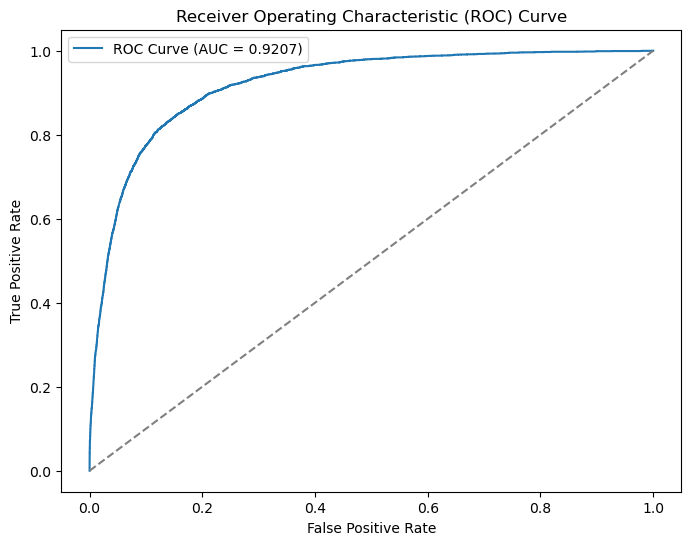


Feature Importances:
                    Feature  Importance
9               pass_height    0.345376
0               pass_length    0.180947
2  gaussian_opponent_weight    0.177888
1                pass_angle    0.087120
4                 log_ratio    0.085205
7                     x_end    0.083614
8                     y_end    0.028661
5                   x_start    0.007786
6                   y_start    0.002881
3  gaussian_teammate_weight    0.000522


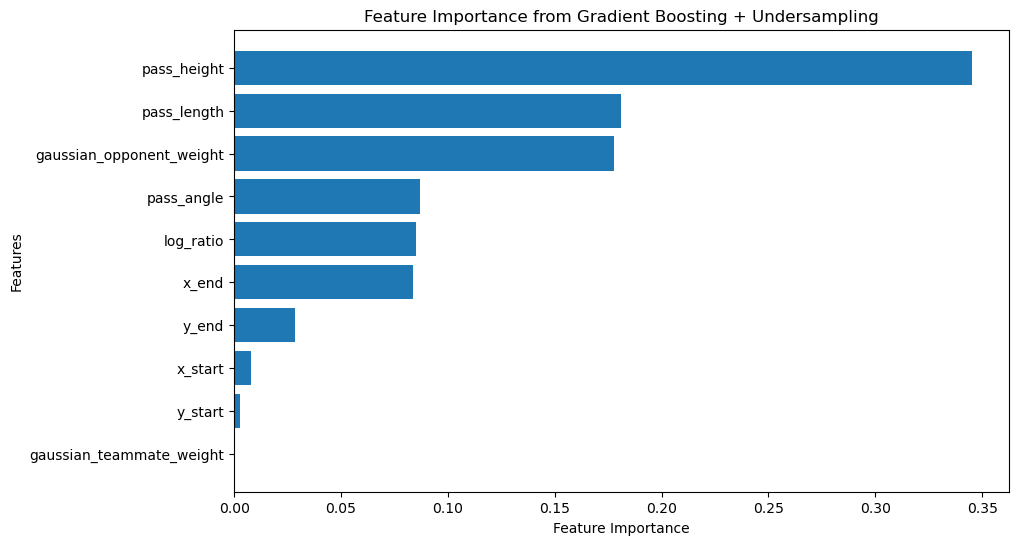

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample


csv_file_path = "all_passes_testing.csv" 
all_passes_df_copy = pd.read_csv(csv_file_path)

if 'location' in all_passes_df_copy.columns and 'pass_end_location' in all_passes_df_copy.columns:
    all_passes_df_copy[['x_start', 'y_start']] = pd.DataFrame(all_passes_df_copy['location'].apply(eval).tolist(), index=all_passes_df_copy.index)
    all_passes_df_copy[['x_end', 'y_end']] = pd.DataFrame(all_passes_df_copy['pass_end_location'].apply(eval).tolist(), index=all_passes_df_copy.index)
else:
    raise KeyError("Columns 'location' and 'pass_end_location' are missing or not formatted correctly.")


pass_height_mapping = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}
all_passes_df_copy['pass_height'] = all_passes_df_copy['pass_height'].map(pass_height_mapping)

if all_passes_df_copy['pass_height'].isnull().any():
    raise ValueError("Some values in 'pass_technique' could not be mapped to 'pass_height'.")


train_data, test_data = train_test_split(
    all_passes_df_copy,
    test_size=0.2,
    random_state=42,
    stratify=all_passes_df_copy['pass_outcome']
)


completed_passes = train_data[train_data['pass_outcome'] == 'Completed']
incomplete_passes = train_data[train_data['pass_outcome'] == 'Incomplete']

completed_undersampled = resample(
    completed_passes,
    replace=False,
    n_samples=len(incomplete_passes),  
    random_state=42
)

balanced_train_data = pd.concat([completed_undersampled, incomplete_passes]).sample(frac=1, random_state=42)


features = ['pass_length', 'pass_angle', 'gaussian_opponent_weight', 
            'gaussian_teammate_weight', 'log_ratio', 'x_start', 'y_start', 'x_end', 'y_end', 'pass_height']


X_train = balanced_train_data[features]
y_train = balanced_train_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})
X_test = test_data[features]
y_test = test_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})


gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train)
y_test_pred = gb_model.predict(X_test)
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

y_test_proba = gb_model.predict_proba(X_test)[:, 1] 
aroc = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC: {aroc:.4f}")

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
aroc = roc_auc_score(y_test, y_test_proba)
gb_recall_class1 = recall_score(y_test, y_test_pred, pos_label=1)  
gb_precision_class1 = precision_score(y_test, y_test_pred, pos_label=1)  


model_results.append({
    'Model': 'Gradient Boosting (Undersampling)',
    'Accuracy': accuracy,
    'F1-Score': f1,
    'AUC-ROC': aroc, 
    'Recall (Class 1)': gb_recall_class1,
    'Precision (Class 1)': gb_precision_class1
})


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {aroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Gradient Boosting + Undersampling')
plt.gca().invert_yaxis() 
plt.show()


Class Weights: {0: np.float64(0.5766231039731275), 1: np.float64(3.762723474210562)}
Training Gradient Boosting...

Test Set Performance:
Accuracy: 0.8464339025011832
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     23817
           1       0.46      0.84      0.59      3650

    accuracy                           0.85     27467
   macro avg       0.72      0.85      0.75     27467
weighted avg       0.90      0.85      0.86     27467


AUC-ROC: 0.9212


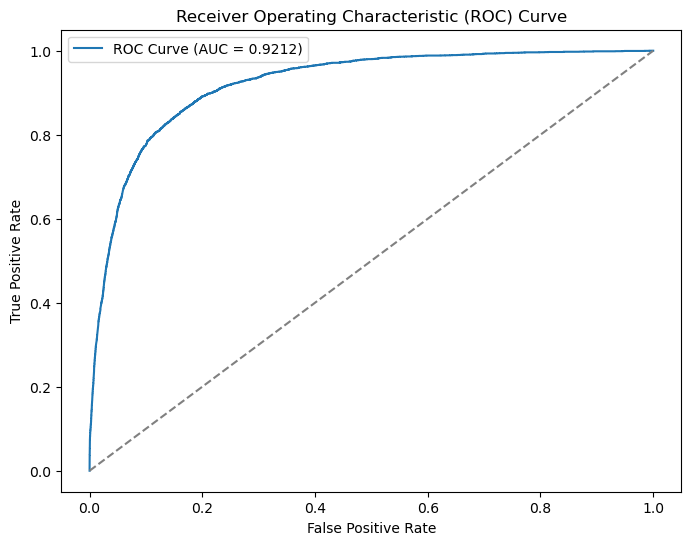


Feature Importances:
                    Feature  Importance
9               pass_height    0.359298
0               pass_length    0.177429
2  gaussian_opponent_weight    0.165401
4                 log_ratio    0.090959
7                     x_end    0.084603
1                pass_angle    0.080682
8                     y_end    0.031852
5                   x_start    0.006343
6                   y_start    0.002842
3  gaussian_teammate_weight    0.000590


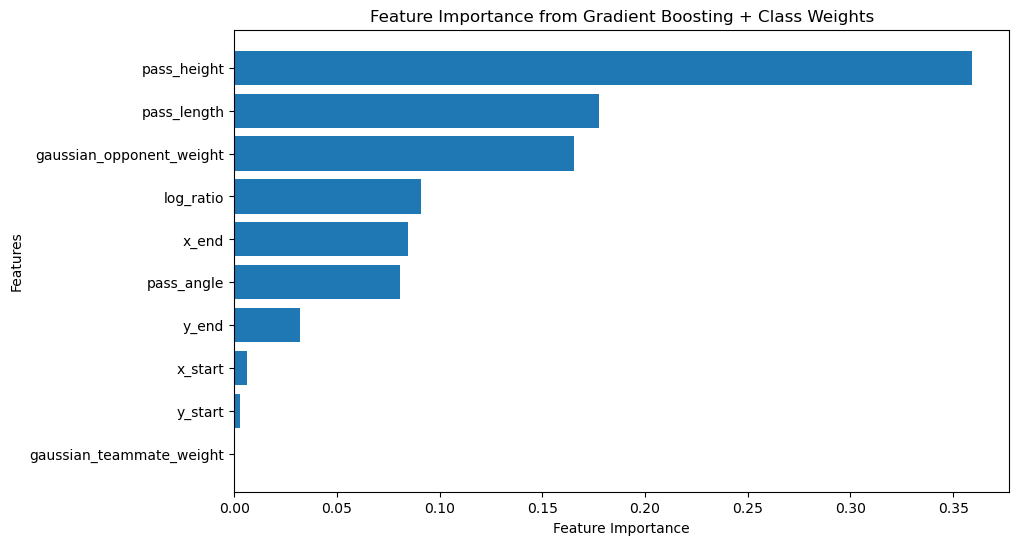

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight


csv_file_path = "all_passes_testing.csv"  
all_passes_df_copy = pd.read_csv(csv_file_path)


if 'location' in all_passes_df_copy.columns and 'pass_end_location' in all_passes_df_copy.columns:
    all_passes_df_copy[['x_start', 'y_start']] = pd.DataFrame(all_passes_df_copy['location'].apply(eval).tolist(), index=all_passes_df_copy.index)
    all_passes_df_copy[['x_end', 'y_end']] = pd.DataFrame(all_passes_df_copy['pass_end_location'].apply(eval).tolist(), index=all_passes_df_copy.index)
else:
    raise KeyError("Columns 'location' and 'pass_end_location' are missing or not formatted correctly.")


pass_height_mapping = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}
all_passes_df_copy['pass_height'] = all_passes_df_copy['pass_height'].map(pass_height_mapping)


if all_passes_df_copy['pass_height'].isnull().any():
    raise ValueError("Some values in 'pass_technique' could not be mapped to 'pass_height'.")


train_data, test_data = train_test_split(
    all_passes_df_copy,
    test_size=0.2,
    random_state=42,
    stratify=all_passes_df_copy['pass_outcome']
)


features = ['pass_length', 'pass_angle', 'gaussian_opponent_weight', 
            'gaussian_teammate_weight', 'log_ratio', 'x_start', 'y_start', 'x_end', 'y_end', 'pass_height']


X_train = train_data[features]
y_train = train_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})
X_test = test_data[features]
y_test = test_data['pass_outcome'].map({'Completed': 0, 'Incomplete': 1})


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class Weights: {class_weight_dict}")

sample_weights = y_train.map(class_weight_dict)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)



print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_test_pred = gb_model.predict(X_test)
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
aroc = roc_auc_score(y_test, y_test_proba)
gb_recall_class1 = recall_score(y_test, y_test_pred, pos_label=1)  
gb_precision_class1 = precision_score(y_test, y_test_pred, pos_label=1)  


model_results.append({
    'Model': 'Gradient Boosting (Class Weights)',
    'Accuracy': accuracy,
    'F1-Score': f1,
    'AUC-ROC': aroc, 
    'Recall (Class 1)': gb_recall_class1,
    'Precision (Class 1)': gb_precision_class1
})


y_test_proba = gb_model.predict_proba(X_test)[:, 1] 
aroc = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC: {aroc:.4f}")


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {aroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Gradient Boosting + Class Weights')
plt.gca().invert_yaxis() 
plt.show()





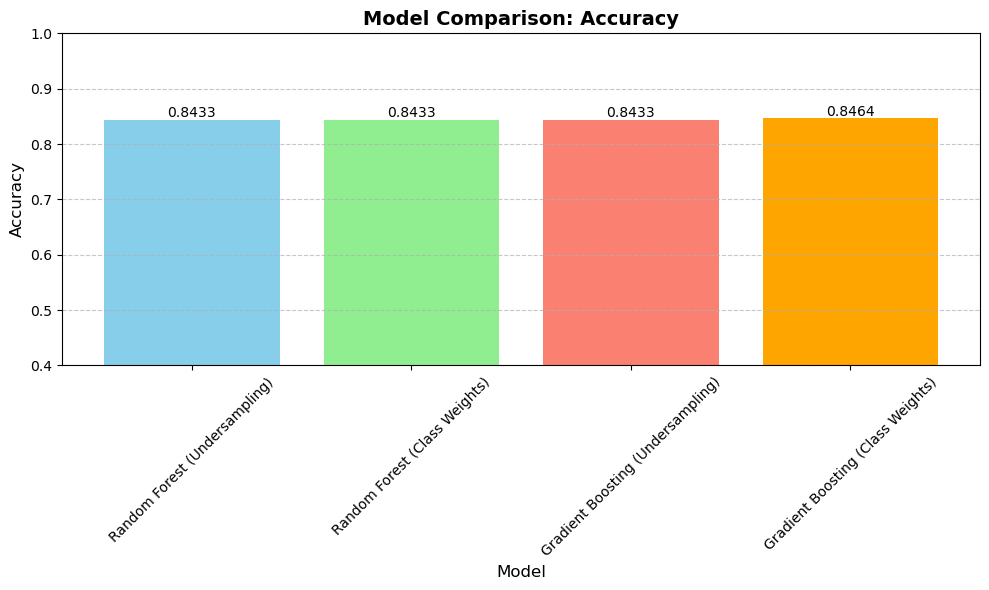

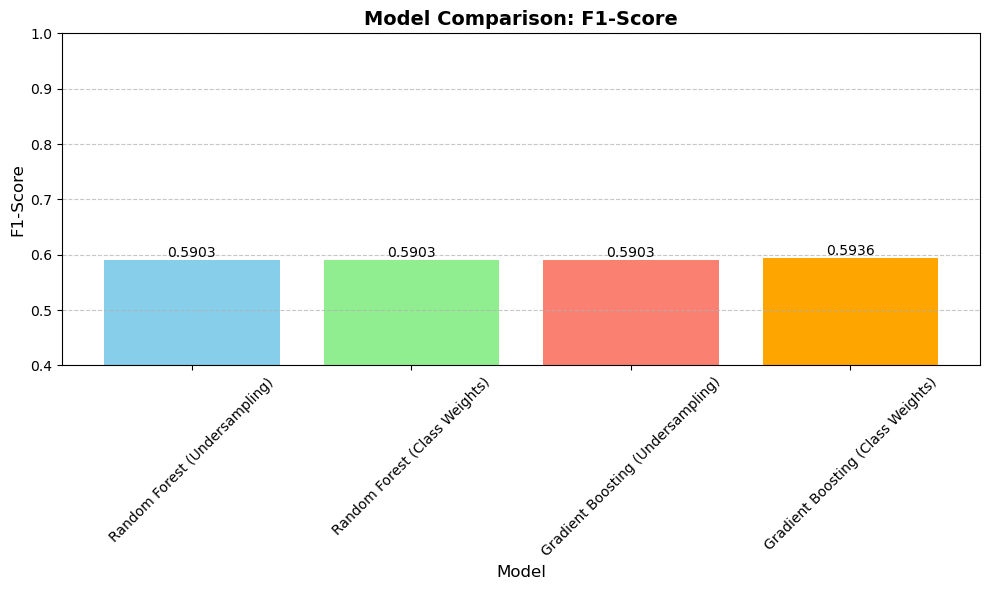

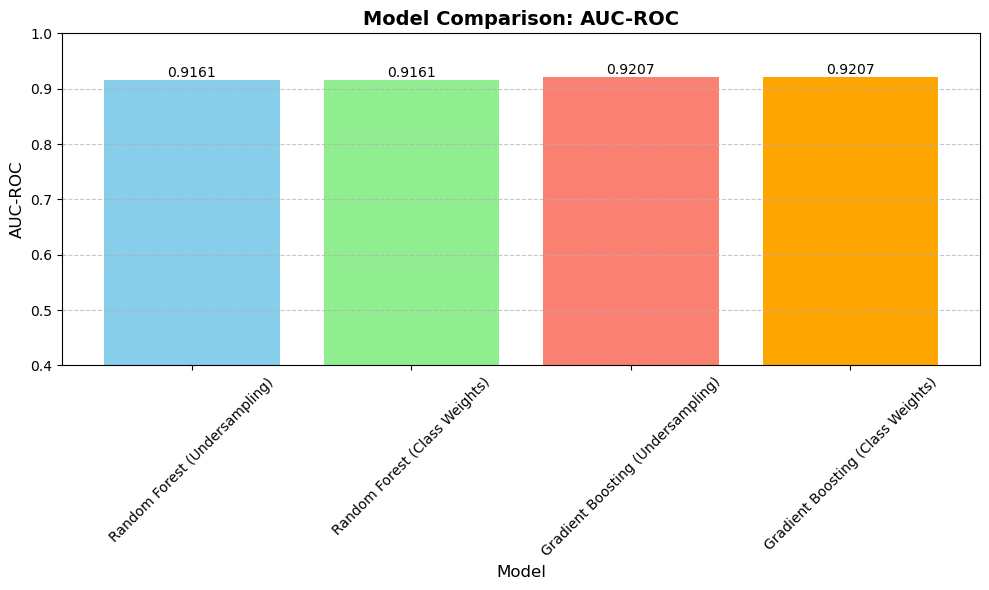

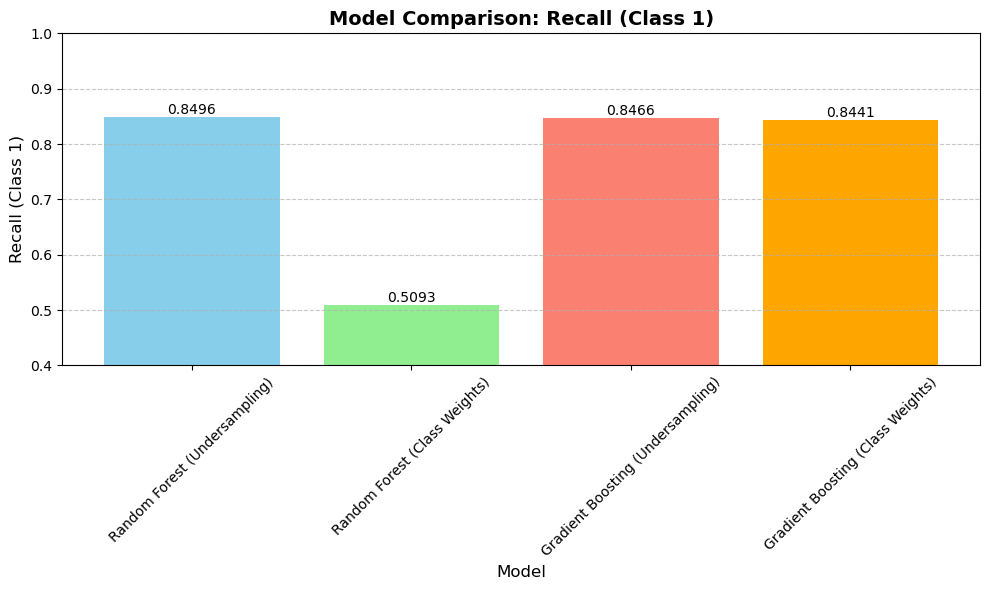

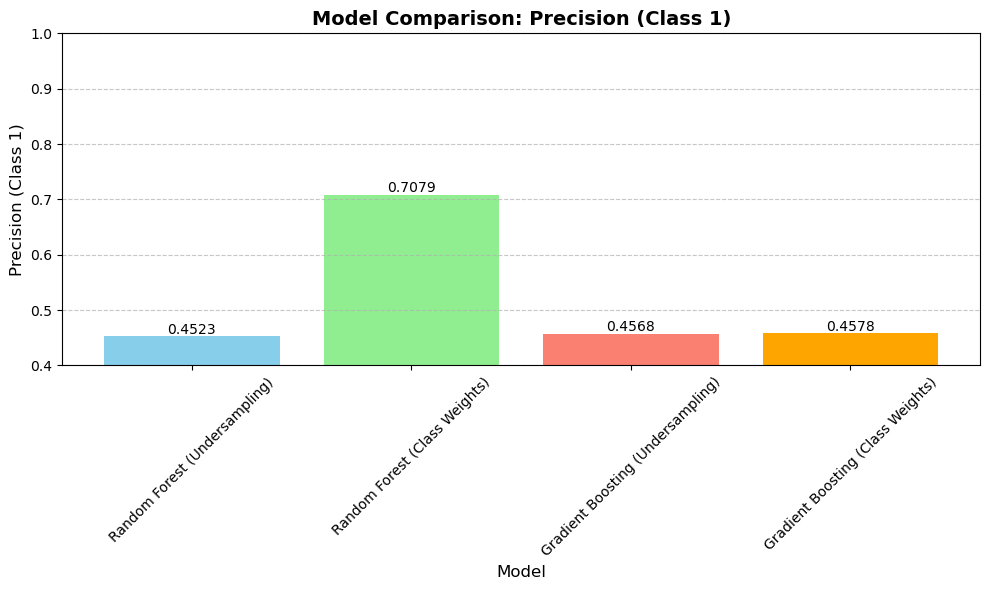

In [91]:
import matplotlib.pyplot as plt
import os


output_dir = "model_comparison_plots"
os.makedirs(output_dir, exist_ok=True)


metrics = ['Accuracy', 'F1-Score', 'AUC-ROC', 'Recall (Class 1)', 'Precision (Class 1)']


for metric in metrics:
    plt.figure(figsize=(10, 6))
    
 
    bars = plt.bar(results_df['Model'], results_df[metric], color=['skyblue', 'lightgreen', 'salmon', 'orange'])
    
   
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.4f}", ha='center', fontsize=10)
    
   
    plt.title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylim(0.4, 1.0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    
    plt.tight_layout() 
    
    output_path = os.path.join(output_dir, f"{metric.replace(' ', '_').lower()}_comparison.png")
    plt.savefig(output_path, dpi=300)  
    
    plt.show()
